In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim
from torchvision import transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt 

In [3]:
# # splitting the train into train and val

# train_set , val_set = random_split(train_set, lengths = [50000,10000])

# # making the dataloader
# batch_size = 32
# train_loader = DataLoader(train_set , shuffle = True , batch_size = batch_size)
# val_loader = DataLoader(val_set , shuffle = False , batch_size = batch_size) 
# test_loader = DataLoader(test_set , shuffle = False , batch_size = batch_size)


In [4]:
def _get_conv_output_size(input_size, out_channels, model):
    batch_size = 1
    input_tensor = torch.autograd.Variable(torch.rand(batch_size, *input_size))
    output_feat = model.features(input_tensor)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

In [5]:
class CNN(nn.Module):
    def __init__(self, out_channels):
        super(CNN, self).__init__()

        conv_layers = []
        num_conv_layers = len(out_channels)

        for i in range(num_conv_layers):
            if i == 0:
                conv_layers.append(nn.Conv2d(1, out_channels[i], kernel_size=3, padding=1))
            else:
                conv_layers.append(nn.Conv2d(out_channels[i-1], out_channels[i], kernel_size=3, padding=1))

            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.features = nn.Sequential(*conv_layers)
        self.fc1 = nn.Linear(_get_conv_output_size((1, 28, 28), out_channels, self), 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [6]:
def cnn_train(out_channels, num_epochs, batch_size, learning_rate, device, plots):
    # Set up transforms
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_dataset = datasets.MNIST(root='./mnist/train', train=True, download=False, transform=transform)
    test_dataset = datasets.MNIST(root='./mnist/test', train=False, download=False, transform=transform)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    cnn_model = CNN(out_channels)
    cnn_model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

    # Lists to track losses and accuracy
    train_losses = []
    test_losses = []
    accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Train the model
        cnn_model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        accuracy = 100 * (correct / total)
        accuracies.append(accuracy)

        # Evaluate the model
        cnn_model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = cnn_model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}")

    if plots:
        # Plot the training and test losses
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot the accuracy
        plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    return cnn_model, (train_losses, test_losses, accuracies)



In [7]:
def cnn_apply(model, test_indexes):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    test_dataset = datasets.MNIST(root='./mnist/test', train=False, download=False, transform=transform)

    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    images = []
    labels_true = []
    for index in test_indexes:
        image, label = test_dataset[index]
        images.append(image)
        labels_true.append(label)

    images = torch.stack(images).to(device)
    labels_true = torch.tensor(labels_true).to(device)

    correct = 0
    with torch.no_grad():
        output = model(images)
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels_true).sum().item()

    accuracy = 100 * correct / len(test_indexes)
    print('Accuracy of the network on the test images: %.2f %%' % accuracy)

    num_images = len(test_indexes)
    columns = min(5, num_images)
    rows = -(-num_images // columns)
    rows = min(rows, 2)  # Limit the maximum number of rows to 2

    fig_width = 2 * columns
    fig_height = 2 * rows
    fig, axes = plt.subplots(rows, columns, figsize=(fig_width, fig_height))

    for i, idx in enumerate(test_indexes[:10]):  # Print only the first 10 images
        image, label = test_dataset[idx]
        ax = axes[i // columns, i % columns]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f"Predicted: {predicted[i].item()}\nTrue: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Epoch [1/10], Train Loss: 0.1248, Test Loss: 0.0573, Accuracy: 96.01
Epoch [2/10], Train Loss: 0.0440, Test Loss: 0.0329, Accuracy: 98.69
Epoch [3/10], Train Loss: 0.0322, Test Loss: 0.0387, Accuracy: 99.02
Epoch [4/10], Train Loss: 0.0263, Test Loss: 0.0393, Accuracy: 99.13
Epoch [5/10], Train Loss: 0.0230, Test Loss: 0.0459, Accuracy: 99.31
Epoch [6/10], Train Loss: 0.0186, Test Loss: 0.0560, Accuracy: 99.40
Epoch [7/10], Train Loss: 0.0171, Test Loss: 0.0481, Accuracy: 99.46
Epoch [8/10], Train Loss: 0.0161, Test Loss: 0.0363, Accuracy: 99.48
Epoch [9/10], Train Loss: 0.0137, Test Loss: 0.0375, Accuracy: 99.57
Epoch [10/10], Train Loss: 0.0125, Test Loss: 0.0402, Accuracy: 99.62


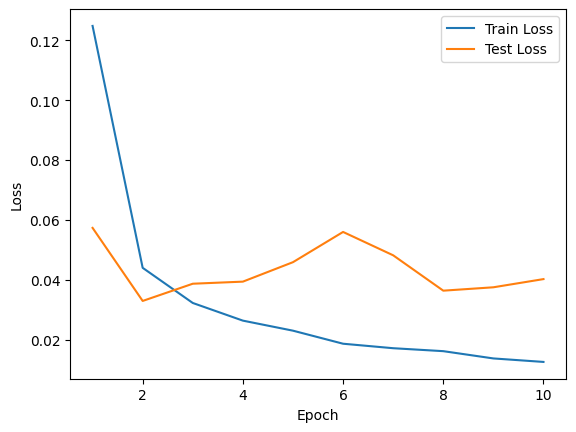

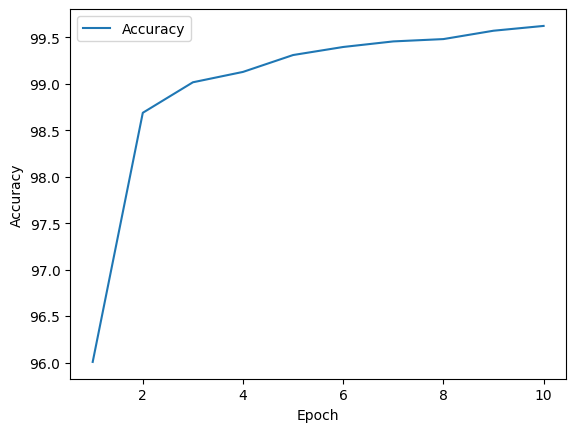

CNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:

# Set the hyperparameters
out_channels = [16, 32, 128]  # Number of output channels in the CNN blocks
num_epochs = 10
batch_size = 34
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plots = True  # Set to True to produce plots of train and test losses

# Train the CNN model
cnn_model, (train_losses, test_losses, accuracies) = cnn_train(out_channels, num_epochs, batch_size, learning_rate, device, plots)
print(cnn_model)

Accuracy of the network on the test images: 100.00 %


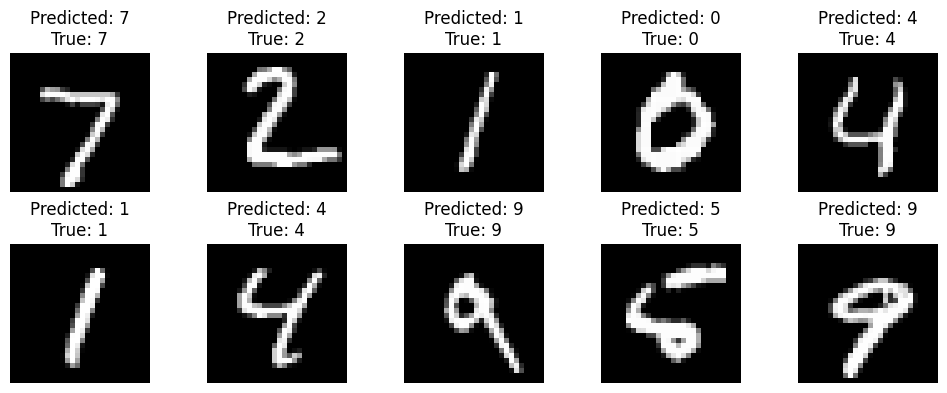

In [12]:
test_indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Indexes of examples from the test set
cnn_apply(cnn_model, test_indexes)

[4621, 231, 6349, 9698, 2092, 8299, 1524, 646, 574, 2974]
Accuracy of the network on the test images: 90.00 %


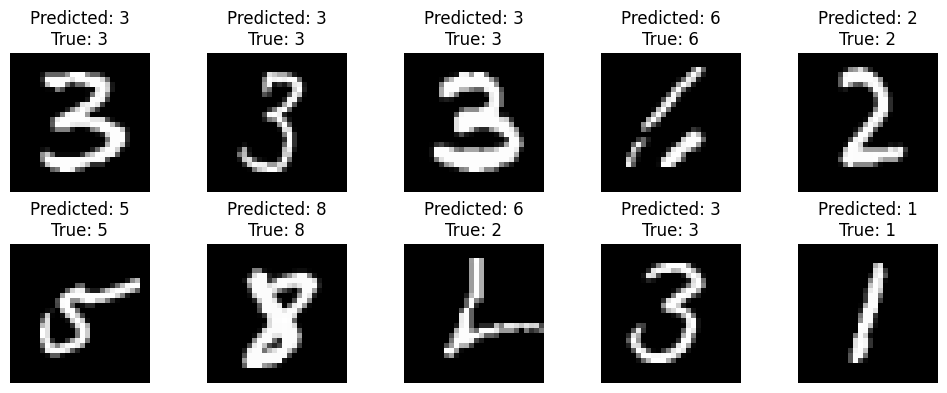

In [13]:
import random

test_indexes = []

for i in range(10):
    test_indexes.append(random.randint(1,10000))

print(test_indexes)

cnn_apply(cnn_model, test_indexes)

In [15]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets(root='./Task1/train', train=True, download=False, transform=transform)
test_dataset = datasets(root='./Task1/test', train=False, download=False, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TypeError: 'module' object is not callable